# Pedestrian avoidance system for self-driving car (server-side)

This example demonstrates AdaStress's remote stress testing capabilities with an example scenario: Alice has designed a pedestrian avoidance system for her self-driving car and would like to make use of Bob's stress testing infrastructure. For reasons of confidentiality and/or security, Alice does not wish to share or reveal the system software.

AdaStress provides an interface by which Bob may connect securely to a server belonging to Alice and perform stress testing. An information gap ensures that he receives no information about the system or its behavior, other than the limited information that Alice chooses to share.

In this scenario, Alice chooses the option that affords maximum privacy: a blackbox salted seed-action simulation. No information about the state or action space is shared, and all seeds are rehashed with a private token. This ensures that Bob could not independently reproduce any failures he finds, even given an exact copy of Alice's software.

*This notebook contains the server-side implementation, consisting of the SUT, simulation, and server creation.*

- **System under test:** proprietary pedestrian avoidance system for self-driving car.
- **Failure criterion:** car comes within certain distance of pedestrian.
- **Stochastic disturbance:** pedestrian movement, normally distributed in acceleration.

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating environment at `C:\Users\rlipkis\.julia\dev\adastress\examples\pedestrian\Project.toml`


## System under test

In [2]:
using AdaStress
using Distributions
using StaticArrays

┌ Info: Precompiling AdaStress [f8632b6a-8763-4da0-bfaf-5f7707adef25]
└ @ Base loading.jl:1317


In [3]:
abstract type Actor end

Base.@kwdef mutable struct SelfDrivingCar <: Actor
    state::MVector{2, Float64}   = MVector(0.0, 0.0) # car state (position, velocity)
    ped_est::MVector{2, Float64} = MVector(0.0, 0.0) # estimated pedestrian state
    α::Float64                   = 0.5               # estimation filter smoothing factor
    t_crit::Float64              = 3.0               # brake if miss time interval is below this value
    br::Float64                  = 3.0               # braking magnitude
end

Base.@kwdef mutable struct Pedestrian <: Actor
    state::MVector{2, Float64} = MVector(0.0, 0.0)
    acc_dist::Distribution     = Normal(0.0, 0.25)
end

# Update internal estimate of pedestrian state.
function sensor_update!(car::SelfDrivingCar, ped::Pedestrian)
    car.ped_est += (1 - car.α) * (ped.state - car.ped_est)
end

# Control law for pedestrian avoidance (system under test). All this secrecy for this???
function pedestrian_avoidance(car::SelfDrivingCar)
    tc = -car.state[1] / car.state[2]      # time until car reaches intersection
    tp = -car.ped_est[1] / car.ped_est[2]  # time until pedestrian reaches intersection
    
    return tc > 0 && tp > 0 && abs(tc - tp) < car.t_crit ? car.br : 0.0
end

pedestrian_avoidance (generic function with 1 method)

## Simulation

The car moves forward on the $x$-axis, while the pedestrian moves on the $y$-axis. The crosswalk is located at the point $(0, 0)$.

In [4]:
distance(car::SelfDrivingCar, ped::Pedestrian) = sqrt(car.state[1]^2 + ped.state[1]^2)

# Update pedestrian state.
function update!(ped::Pedestrian, dt::Float64)
    acc = rand(ped.acc_dist)
    ped.state[1] += ped.state[2] * dt + 0.5 * acc * dt^2
    ped.state[2] += acc * dt
    return logpdf(ped.acc_dist, acc) - logpdf(ped.acc_dist, 0.0)
end

# Update car state with nonnegative braking value.
function update!(car::SelfDrivingCar, br::Float64, dt::Float64)
    if br * dt <= car.state[2]
        car.state[1] += car.state[2] * dt - 0.5 * br * dt^2
        car.state[2] += -br * dt
    else
        # braking can't reverse car
        car.state[1] += 0.5 * car.state[2]^2 / br
        car.state[2] = 0.0
    end
end

Base.@kwdef mutable struct DriveSim <: AdaStress.BlackBox
    t::Float64          = 0.0
    dt::Float64         = 1.0
    t_max::Float64      = 15.0
    car::SelfDrivingCar = SelfDrivingCar()
    ped::Pedestrian     = Pedestrian()
    d_crit::Float64     = 2.0
end

function initialize!(sim::DriveSim)
    sim.t = 0.0
    sim.car.state .= MVector(-100.0, 10.0)
    sim.ped.state .= MVector(-10.0, 0.5)
    sim.car.ped_est .= MVector(-10.0, 0.5)
end

function update!(sim::DriveSim)
    sim.t += sim.dt
    
    # pedestrian update
    logprob = update!(sim.ped, sim.dt)
    
    # car response
    sensor_update!(sim.car, sim.ped)
    br = pedestrian_avoidance(sim.car)
    update!(sim.car, br, sim.dt)
    
    return logprob
end

update! (generic function with 3 methods)

In [5]:
AdaStress.reset!(sim::DriveSim) = initialize!(sim)
AdaStress.step!(sim::DriveSim) = update!(sim)
AdaStress.isterminal(sim::DriveSim) = sim.t >= sim.t_max
AdaStress.isevent(sim::DriveSim) = distance(sim.car, sim.ped) < sim.d_crit
AdaStress.distance(sim::DriveSim) = max(distance(sim.car, sim.ped) - sim.d_crit, 0.0)

## Server set-up

In [6]:
mdp = AdaStress.ASTMDP(DriveSim())
mdp.reward.event_bonus = 1000.0

1000.0

In [7]:
server = AdaStress.ASTServer(mdp, Interface.IPv4(0), 2000)

AdaStress.Interface.ASTServer(ip"0.0.0.0", 2000, nothing, AdaStress.Interface.ASTMDP{AdaStress.Interface.UnobservableState, AdaStress.Interface.SeedAction}(DriveSim(0.0, 1.0, 15.0, SelfDrivingCar([-100.0, 10.0], [-10.0, 0.5], 0.5, 3.0, 3.0), Pedestrian([-10.0, 0.5], Normal{Float64}(μ=0.0, σ=0.25)), 2.0), AdaStress.Interface.Reward(true, AdaStress.Interface.GradientHeuristic(), 1000.0, AdaStress.Interface.WeightedObjective(1.0, 1.0, 1.0)), Dict{Symbol, AdaStress.Interface.VariableInfo}(), MersenneTwister(0x925a132de6eba9959a9d744419675476, (0, 1002, 0, 318))), nothing, false)

In [8]:
Interface.set_password(server)

Enter password: ········


┌ Info: Private token set.
└ @ AdaStress.Interface C:\Users\rlipkis\.julia\dev\AdaStress\src\interface\remote\server.jl:51


In [9]:
Interface.connect!(server)

Task (runnable) @0x0000000045079c30

┌ Info: Connected to AST client.
│   conn = Sockets.TCPSocket(Base.Libc.WindowsRawSocket(0x0000000000000f4c) open, 0 bytes waiting)
└ @ AdaStress.Interface C:\Users\rlipkis\.julia\dev\AdaStress\src\interface\remote\server.jl:78


## Visualization / analysis

In [10]:
using BSON
using DataStructures
using Plots

In [11]:
BSON.@load "best_paths.bson" sol

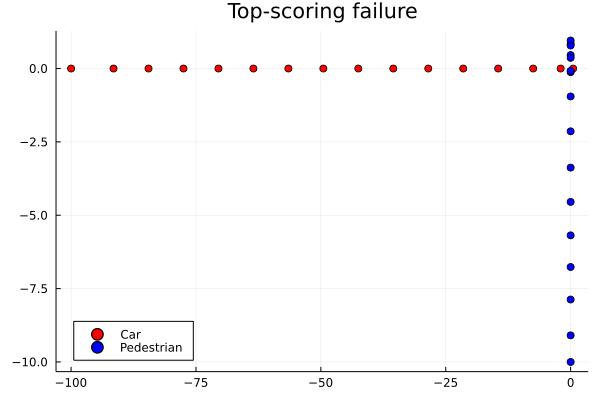

In [12]:
path = collect(keys(sol))[end]

Interface.reset!(mdp)
xs = [mdp.sim.car.state[1]]
ys = [mdp.sim.ped.state[1]]

for a in path
    a = Interface.reseed(a, server.token) # without reseeding, results are completely encrypted
    Interface.act!(mdp, a)
    push!(xs, mdp.sim.car.state[1])
    push!(ys, mdp.sim.ped.state[1])
end

p = plot(title="Top-scoring failure", legend=:bottomleft)
scatter!(p, xs, zeros(length(xs)); mc=:red, label="Car")
scatter!(p, zeros(length(ys)), ys; mc=:blue, label="Pedestrian")

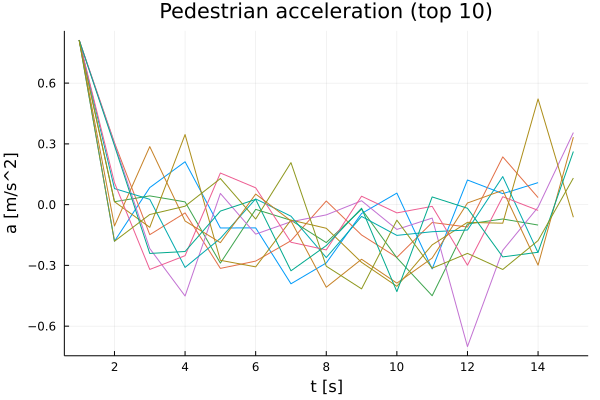

In [13]:
acc_paths = []

for path in collect(keys(sol))
    Interface.reset!(mdp)
    vs = [mdp.sim.ped.state[2]]
    for a in path
        a = Interface.reseed(a, server.token)
        Interface.act!(mdp, a)
        push!(vs, mdp.sim.ped.state[2])
    end
    push!(acc_paths, diff(vs))
end

p = plot(title="Pedestrian acceleration (top $(length(acc_paths)))", xlabel="t [s]", ylabel="a [m/s^2]")
for acc in acc_paths
    plot!(p, acc; label=false)
end
p